In [1]:
import warnings

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pingouin as pg
import seaborn as sns
from scipy import stats

warnings.filterwarnings("ignore")

In [2]:
# Loading COHA time series data
ts_df = pd.read_csv("./data/SWOW_prediction/eval/time_series/ts_df.csv")
ts_df = (
    ts_df.groupby(["words", "year", "property"])[["count", "outputs_z"]]
    .mean()
    .reset_index()
)
ts_df["property_z"] = ts_df["outputs_z"]

In [3]:
def get_disease_dataframe():
    category_norms = pd.read_csv(
        "./data/Referential version_Item level data.csv",
    )  # diseases from category norm dataset
    category_norms = category_norms.loc[category_norms["prod.freq"] > 1]
    disease_members = category_norms.loc[category_norms.category == "disease"][
        "category.member"
    ].unique()

    epi_df = pd.read_csv(
        "./data/moralization_terms/epidemics.csv",
    )  # wikipedia list of epidemics
    epidemic_cues = []
    for i, row in epi_df.iterrows():
        row_terms = row["Terms"].split(",")
        new_rows = [s.lower().strip() for s in row_terms]
        epidemic_cues += new_rows

    disease_df = pd.read_csv(
        "./data/moralization_terms/diseases.csv",
    )  # wikipedia list of diseases
    disease_cues = []
    for i, row in disease_df.iterrows():
        row_terms = row["Terms"].split(",")
        new_rows = [s.lower().strip() for s in row_terms]
        disease_cues += new_rows

    all_cues = set(epidemic_cues + disease_cues + list(disease_members))  # All diseases
    all_cues.remove("cold")  # Removing ambiguous term 'cold'

    disease_ts_df = ts_df.loc[
        (ts_df.words.isin(all_cues)) & (ts_df["count"] >= 50)
    ].reset_index(drop=True)

    # Calculating the mean relevance of disease terms at each decade
    mean_relevances = disease_ts_df.loc[(disease_ts_df.property == "previous_link")]
    mean_relevances = (
        mean_relevances.groupby(["words", "year"]).outputs_z.mean().reset_index()
    )

    # Calculating the mean relevance of disease terms at each decade
    moral_polarities = disease_ts_df.loc[(disease_ts_df.property == "polarity")]
    moral_polarities = (
        moral_polarities.groupby(["words", "year"]).outputs_z.mean().reset_index()
    )

    # Creating control dataframe without disease terms
    all_df = (
        ts_df.loc[
            (ts_df["count"] >= 50)
            & (~ts_df.words.isin(all_cues))
            & (ts_df.property == "previous_link")
        ]
        .groupby(["words", "year"])
        .outputs_z.mean()
        .reset_index()
    )

    # Creating control dataframe without disease terms (for morality)
    all_polarity_df = (
        ts_df.loc[
            (ts_df["count"] >= 50)
            & (~ts_df.words.isin(all_cues))
            & (ts_df.property == "polarity")
        ]
        .groupby(["words", "year"])
        .outputs_z.mean()
        .reset_index()
    )

    return (
        all_cues,
        disease_ts_df,
        mean_relevances,
        moral_polarities,
        all_df,
        all_polarity_df,
    )

In [4]:
all_cues, disease_ts_df, mean_relevances, moral_polarities, all_df, all_polarity_df = (
    get_disease_dataframe()
)

In [10]:
len(disease_ts_df.words.unique())

22

In [5]:
disease_ts_df.words.unique()

array(['anthrax', 'cancer', 'cholera', 'diabetes', 'diphtheria', 'flu',
       'hepatitis', 'hiv', 'hivaids', 'influenza', 'leukemia', 'malaria',
       'measles', 'plague', 'polio', 'salmonella', 'scarlet fever',
       'smallpox', 'tuberculosis', 'typhoid', 'typhus', 'yellow fever'],
      dtype=object)

In [11]:
mean_relevances.sample(4)  # (disease, year, moral relevance)

,words,year,outputs_z
40,flu,2000,0.792568
82,plague,1900,1.579608
101,salmonella,2000,0.837090
117,tuberculosis,1940,2.442727


In [12]:
def get_mean_values(all_df, mean_relevances, year_column):
    """Function to create create a bootstrap sample of the mean relevance of non-disease terms for controlling

    Args:
        all_df (pd.DataFrame): Dataframe containing the moral relevance of all words that are not disease terms
        mean_relevances (pd.DataFrame): Dataframe containing the relevance of disease terms
        year_column (str): Column name for the year in the dataframe

    Returns:
        mean_values (list): List of mean relevance values for the bootstrap samples
        new_df (pd.DataFrame): Dataframe containing a randomly sampled control data

    """
    B = 1000
    mean_values = []
    all_df = all_df.copy(deep=True)
    all_df.set_index("year", inplace=True)

    for b in range(B):
        all_dfs = []
        if b % 100 == 0:
            print(b)
        new_df = pd.DataFrame()
        for i, row in mean_relevances.iterrows():
            year = row[year_column]
            new_row = all_df.loc[all_df.index == year]
            if len(new_row) > 0:
                all_dfs.append(new_row.sample(1))
        new_df = pd.concat(all_dfs, ignore_index=True)
        mean_values.append(new_df.outputs_z.mean())
    return mean_values, new_df

In [13]:
disease_random_mean_values, disease_random_df = get_mean_values(
    all_df, mean_relevances, "year",
)

0
100
200
300
400
500
600
700
800
900


### Let's compare the moral relevance of diseases terms with a bootstrapped mean of moral relevance for non-disease terms

In [14]:
print(
    pg.ttest(
        disease_random_mean_values, mean_relevances.outputs_z.mean(), alternative="less",
    ),
)  # diseases are more relevant than random terms

                 T  dof alternative  p-val          CI95%    cohen-d BF10  \
T-test -669.985784  999        less    0.0  [-inf, -0.01]  21.186811  inf   

        power  
T-test    1.0  


In [15]:
# Reapting the process for moral polarity
disease_random_mean_polarity_values, disease_polarity_random_df = get_mean_values(
    all_polarity_df, moral_polarities, "year",
)

0
100
200
300
400
500
600
700
800
900


In [16]:
print(
    pg.ttest(
        disease_random_mean_polarity_values,
        moral_polarities.outputs_z.mean(),
        alternative="greater",
    ),
)  # diseases are more morally negative than random terms

                 T  dof alternative  p-val        CI95%    cohen-d BF10  power
T-test  939.745457  999     greater    0.0  [0.02, inf]  29.717361  inf    1.0


### Let's compare the valence of disease terms with the moral relevance scores

In [33]:
sentiment_df = pd.read_csv("./data/SWOW_prediction/eval/coha_sentiments.csv")

In [42]:
mean_relevances = mean_relevances.merge(
    sentiment_df, on=["words", "year"], how="left",
).dropna()

In [43]:
disease_relevance_sentiment = (
    mean_relevances.groupby("words")[["outputs_z", "sentiments"]].mean().reset_index()
)
pearson_r, pval = stats.pearsonr(
    disease_relevance_sentiment.outputs_z, disease_relevance_sentiment.sentiments,
)
print("Pearson r:", pearson_r)
print("p-value:", pval)  # Pearson correlation between moral relevance and sentiment

Pearson r: 0.04261087982195312
p-value: 0.8584309926539557


In [47]:
moral_polarities = moral_polarities.merge(
    sentiment_df, on=["words", "year"], how="left",
).dropna()
disease_polarity_sentiment = (
    moral_polarities.groupby("words")[["outputs_z", "sentiments"]].mean().reset_index()
)
pearson_r, pval = stats.pearsonr(
    disease_polarity_sentiment.outputs_z, disease_polarity_sentiment.sentiments,
)
print("Pearson r:", pearson_r)
print("p-value:", pval)

Pearson r: -0.06210098787252401
p-value: 0.7947926345915525


### Conclusion: No significant correlation between moral association scores and sentiment scores for dieases terms!

# Let's study moral association scores of political leaders

In [50]:
leader_data = pd.read_csv("./data/wikipedia_political_ts_df.csv")  # political leaders

In [51]:
import os

decades = np.arange(1850, 2010, 10)
baby_names = set()
for decade in decades:

    years = np.arange(decade, decade + 10)
    for year in years:
        file_dir = f"./data/names/yob{year}.txt"  # Data set of baby names in the United States. (Download seperately)
        if os.path.exists(file_dir):
            with open(file_dir) as f:
                lines = f.readlines()
                for line in lines:
                    name, gender, count = line.split(",")
                    count = int(count)
                    name = name.lower()
                    baby_names.add(name)
baby_ts_df = ts_df.loc[
    (ts_df["count"] >= 50)
    & (ts_df.property == "previous_link")
    & (ts_df.words.isin(baby_names))
]
baby_ts_df_polarity = ts_df.loc[
    (ts_df["count"] >= 50)
    & (ts_df.property == "polarity")
    & (ts_df.words.isin(baby_names))
]

In [52]:
politic_mean_relevances = (
    leader_data.groupby(["Query", "Decade"]).Moral_relevance.mean().reset_index()
)

politic_mean_relevances["outputs_z"] = politic_mean_relevances.Moral_relevance

In [53]:
politic_mean_polarities = (
    leader_data.groupby(["Query", "Decade"]).Moral_polarity.mean().reset_index()
)
politic_mean_polarities["outputs_z"] = politic_mean_polarities.Moral_polarity

In [54]:
print(len(politic_mean_relevances))
politic_mean_relevances

65


,Query,Decade,Moral_relevance,outputs_z
0,Abraham Lincoln,1860,1.408266,1.408266
1,Adolf Hitler,1940,2.084618,2.084618
2,Ahmed Sékou Touré,1980,-0.163273,-0.163273
3,Andrew Johnson,1860,1.128079,1.128079
4,Benito Mussolini,1940,0.331907,0.331907
...,...,...,...,...
60,William McKinley,1900,0.489170,0.489170
61,Winston Churchill,1940,0.729539,0.729539
62,Woodrow Wilson,1920,0.897606,0.897606
63,Yuri Andropov,1980,-0.924460,-0.924460


In [55]:
random_name_mean_values, random_name_df = get_mean_values(
    baby_ts_df, politic_mean_relevances, "Decade",
)

0
100
200
300
400
500
600
700
800
900


In [56]:
pg.ttest(
    random_name_mean_values,
    politic_mean_relevances.Moral_relevance.mean(),
    alternative="less",
)  # political leaders are more morally relevant than random names

,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,-217.343694,999,less,0.0,"[-inf, -0.05]",6.873011,inf,1.0


In [57]:
random_name_polarity_values, random_polarity_name_df = get_mean_values(
    baby_ts_df_polarity, politic_mean_polarities, "Decade",
)

0
100
200
300
400
500
600
700
800
900


In [58]:
pg.ttest(
    random_name_polarity_values,
    politic_mean_polarities.Moral_polarity.mean(),
    alternative="less",
)  # political leaders are more positive than random names

,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,-117.36516,999,less,0.0,"[-inf, 0.08]",3.711412,inf,1.0


-0.18340367018250525 0.1468111344530072
                 T  dof alternative  p-val          CI95%    cohen-d BF10  \
T-test -673.152902  999        less    0.0  [-inf, -0.01]  21.286964  inf   

        power  
T-test    1.0  
Effect size: 2.214826354961754
Two group t-test:                 T         dof alternative         p-val        CI95%  \
T-test  18.204392  210.512077     greater  2.092581e-45  [1.57, inf]   

         cohen-d       BF10  power  
T-test  2.214826  1.607e+45    1.0  
--------
-0.2826039612432996 0.17060643220405863
TtestResult(statistic=-217.34369396011235, pvalue=0.0, df=999)
Effect size: 0.9875746688921737
Two group t-test:                T  dof alternative         p-val        CI95%   cohen-d  \
T-test  5.687735   64     greater  1.719418e-07  [0.56, inf]  0.987575   

             BF10  power  
T-test  8.462e+04    1.0  
                 T  dof alternative  p-val          CI95%   cohen-d BF10  \
T-test -217.343694  999        less    0.0  [-inf, -0.05]  6.873

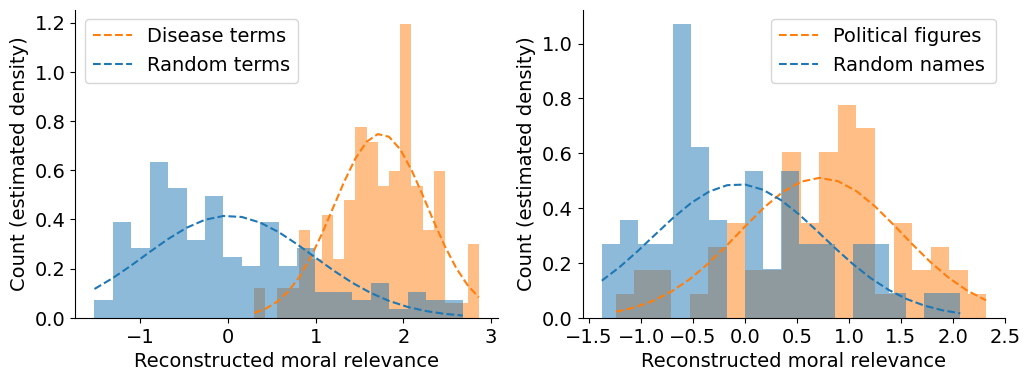

In [59]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
ax = axes[0]
std = np.std(disease_random_mean_values)
mu = np.mean(disease_random_mean_values)
print(mu - 2 * std, mu + 2 * std)

print(
    pg.ttest(
        disease_random_mean_values, mean_relevances.outputs_z.mean(), alternative="less",
    ),
)
print(
    "Effect size:",
    pg.compute_effsize(
        mean_relevances.outputs_z,
        disease_random_df.outputs_z,
        paired=True,
        eftype="cohen",
    ),
)

print(
    "Two group t-test:",
    pg.ttest(
        mean_relevances.outputs_z,
        disease_random_df.outputs_z,
        paired=True,
        alternative="greater",
    ),
)
z_score = (mean_relevances.outputs_z.mean() - mu) / std
# print('Zscore:', z_score, 1 - stats.norm.cdf(z_score))
rng = np.random.default_rng(19680801)
X = rng.normal(loc=mu, scale=std, size=420)

num_bins = 42
std = mean_relevances.outputs_z.std()
mu = mean_relevances.outputs_z.mean()
rng = np.random.default_rng(19680801)
X = rng.normal(loc=mu, scale=std, size=420)

num_bins = 20
n, bins, patches = ax.hist(
    mean_relevances.outputs_z, num_bins, density=True, color="tab:orange", alpha=0.5,
)

y = (1 / (np.sqrt(2 * np.pi) * std)) * np.exp(-0.5 * (1 / std * (bins - mu)) ** 2)
ax.plot(bins, y, "--", color="tab:orange", label="Disease terms")
ax.set_ylabel("Count (estimated density)", fontsize=14)

std = disease_random_df.outputs_z.std()
mu = disease_random_df.outputs_z.mean()
rng = np.random.default_rng(19680801)
X = rng.normal(loc=mu, scale=std, size=420)
num_bins = 20
n, bins, patches = ax.hist(
    disease_random_df.outputs_z, num_bins, density=True, color="tab:blue", alpha=0.5,
)

y = (1 / (np.sqrt(2 * np.pi) * std)) * np.exp(-0.5 * (1 / std * (bins - mu)) ** 2)
ax.plot(bins, y, "--", color="tab:blue", label="Random terms")

ax.legend(fontsize=14)
ax.set_xlabel(r"Reconstructed moral relevance", fontsize=14)
ax.set_xticklabels(ax.get_xticklabels(), fontsize=14)
ax.set_yticklabels(ax.get_yticklabels(), fontsize=14)


ax = axes[1]
print("--------")
std = np.std(random_name_mean_values)
mu = np.mean(random_name_mean_values)
print(mu - 2 * std, mu + 2 * std)
print(
    stats.ttest_1samp(
        random_name_mean_values,
        popmean=politic_mean_relevances.Moral_relevance.mean(),
        alternative="less",
    ),
)
z_score = (politic_mean_relevances.Moral_relevance.mean() - mu) / std

print(
    "Effect size:",
    pg.compute_effsize(
        politic_mean_relevances.Moral_relevance,
        random_name_df.outputs_z,
        paired=True,
        eftype="cohen",
    ),
)

print(
    "Two group t-test:",
    pg.ttest(
        politic_mean_relevances.outputs_z,
        random_name_df.outputs_z,
        paired=True,
        alternative="greater",
    ),
)

z_score = (politic_mean_relevances.Moral_relevance.mean() - mu) / std
print(
    pg.ttest(
        random_name_mean_values,
        politic_mean_relevances.outputs_z.mean(),
        alternative="less",
    ),
)


rng = np.random.default_rng(19680801)
X = rng.normal(loc=mu, scale=std, size=420)

num_bins = 42


std = politic_mean_relevances.Moral_relevance.std()
mu = politic_mean_relevances.Moral_relevance.mean()
rng = np.random.default_rng(19680801)
X = rng.normal(loc=mu, scale=std, size=420)

num_bins = 20
n, bins, patches = ax.hist(
    politic_mean_relevances.Moral_relevance,
    num_bins,
    density=True,
    color="tab:orange",
    alpha=0.5,
)

y = (1 / (np.sqrt(2 * np.pi) * std)) * np.exp(-0.5 * (1 / std * (bins - mu)) ** 2)
ax.plot(bins, y, "--", color="tab:orange", label="Political figures ")
ax.set_ylabel("Count (estimated density)", fontsize=14)
std = random_name_df.outputs_z.std()
mu = random_name_df.outputs_z.mean()
rng = np.random.default_rng(19680801)
X = rng.normal(loc=mu, scale=std, size=420)
num_bins = 20
n, bins, patches = ax.hist(
    random_name_df.outputs_z, num_bins, density=True, color="tab:blue", alpha=0.5,
)

y = (1 / (np.sqrt(2 * np.pi) * std)) * np.exp(-0.5 * (1 / std * (bins - mu)) ** 2)
ax.plot(bins, y, "--", color="tab:blue", label="Random names")
ax.set_xticklabels(ax.get_xticklabels(), fontsize=14)
ax.set_yticklabels(ax.get_yticklabels(), fontsize=14)

plt.legend(fontsize=14)
ax.set_xlabel(r"Reconstructed moral relevance", fontsize=14)

sns.despine()

# plt.savefig('figs/coha_2b.png', dpi = 400, bbox_inches = 'tight')
# plt.savefig('figs/coha_2b.pdf', dpi = 400, bbox_inches = 'tight')

## We can visualize each word and its average moral relevance below

In [60]:
mean_relevances["Query"] = mean_relevances.words
mean_relevances["Moral_relevance"] = mean_relevances.outputs_z
mean_relevances["Decade"] = mean_relevances.year
mean_relevances["Category"] = ["Disease"] * len(mean_relevances)
politic_mean_relevances["Category"] = ["Political figure"] * len(
    politic_mean_relevances,
)

joint_df = pd.concat((mean_relevances, politic_mean_relevances), ignore_index=True)
joint_df = joint_df.groupby(["Query", "Category"]).Moral_relevance.mean().reset_index()

In [61]:
from adjustText import adjust_text

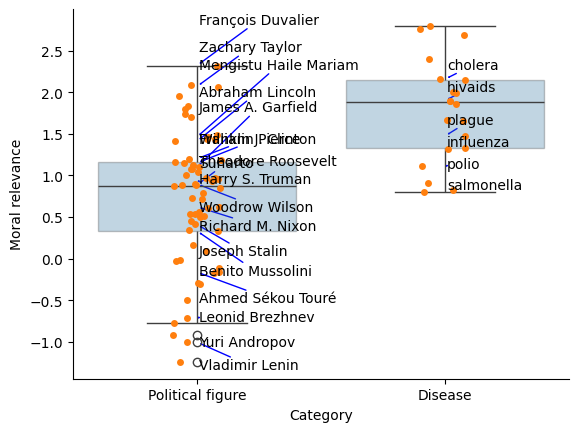

In [62]:
sns.boxplot(data=joint_df, x="Category", y="Moral_relevance", boxprops={"alpha": 0.3})
g = sns.stripplot(data=joint_df, x="Category", y="Moral_relevance")
annotations = []
for i, row in joint_df.iterrows():
    rn = np.random.random()

    x = 0 if row["Category"] == "Political figure" else 1
    y = row["Moral_relevance"]
    if rn <= 0.2 or (x == 1 and rn <= 0.3):
        # g.text(x = x, y = y, s = row['Query'])
        annotations.append(g.annotate(row["Query"], (x, y), color="black"))


adjust_text(
    annotations, expand=(1, 1.5), arrowprops=dict(arrowstyle="->", color="blue"),
)

g.set_ylabel("Moral relevance")

sns.despine()